# Getting to Know Your Observing Mode (Scenario)

The observing mode encodes all of the information related to propagation of star, planet, and other light from the telescope primary all the way through to the science focal plane.  The observing mode is a combination of a `scienceInstrument` (https://exosims.readthedocs.io/en/latest/opticalsystem.html#science-instruments), a `starlightSuppressionSystem` (for Roman, this is always a coronagraph; https://exosims.readthedocs.io/en/latest/opticalsystem.html#starlight-suppression-system) and information on how these are to be used together. 

This notebook demonstrates some methods by which you can interrogate the observing mode to figure out exactly what's inside, and what your exposure time calculations are being based on.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway" 
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
from corgietc.corgietc import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import copy
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

We will load our standard input specification and use it to build an optical system, from which we will extract the first observing mode for inspection:

In [2]:
# Load the default input specification
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())
# create an optical system
OS = corgietc(**copy.deepcopy(specs))
# pull out the first mode
mode = OS.observingModes[0]

The observing mode is a dictionary. First, let's look at all of the keys in it:

In [3]:
for key in mode.keys():
    print(key)

instName
systName
Scenario
lam
SNR
strayLight
timeMultiplier
detectionMode
inst
syst
deltaLam
BW
IWA
OWA
bandpass_model
bandpass_step
bandpass
F0
attenuation
deltaLam_eff
losses
f_SR
stray_ph_s_pix
inBandFlux0_sum
hex
index


## Observing Mode Contents

`instName` and `systName` are the names of `scienceInstrument` and `starlightSuppressionSystem` that make up the mode, while `Scenario` is the name of the mode.  The mode includes two other identifiers: `index` is the numerical index of the mode (in the order it was provided in the original input specification), while `hex` is a unique string that encodes all of the parameters that define the mode.  This last value is used internally to ensure that we can uniquely associate modes with other calculated data.

In addition to the instrument and coronagraph, the mode includes multiple other parameters, the most important of which is `SNR`. This is the target SNR for all observations computed with this mode. We can check its value for the current mode:

In [4]:
mode["SNR"]

5.0

The mode includes a model of its bandpass.  By default, this is a box with central wavelength `lam` and width given by `deltaLam`, such that `deltaLam/lam = BW`, the bandwidth:

In [5]:
print(f'lambda: {mode["lam"]}, Delta lambda:{mode["deltaLam"]}, BW: {mode["BW"]}')
mode["lam"]*mode["BW"] == mode["deltaLam"]

lambda: 575.0 nm, Delta lambda:57.5 nm, BW: 0.1


True

The bandpass is a `synphot` `SpectralElement` object (https://synphot.readthedocs.io/en/latest/synphot/bandpass.html) and we can use it's built-in plotting method to visualize it:

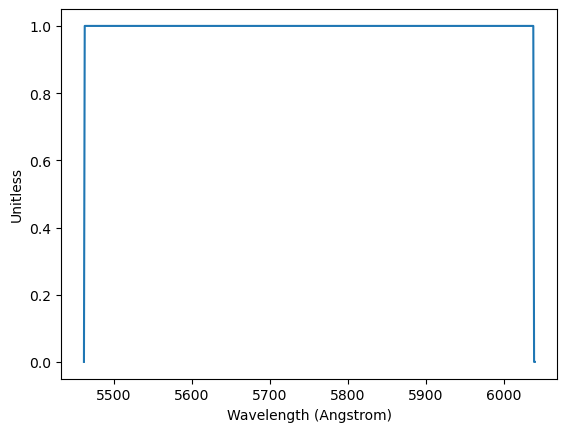

In [6]:
mode["bandpass"].plot()

The type of bandpass to model is governed by the `bandpass_model` key, but note that changing this key after the mode has been defined will not update the bandpass - this must be set in the original input specification.

**Important**: Some of the mode keywords are used by other ETCs in ``EXOSIMS`` and are irrelevant to `corgietc`. These include: `detectionMode, attenuation, losses`.

## Science Instrument Contents

The `scienceInstrument` is also a dictionary.  Let's see what's inside:

In [7]:
inst = mode["inst"]
for key in inst.keys():
    print(key)

name
CritLam
pixelSize
QE
DET_QE_Data
DET_CBE_Data
pp_Factor_CBE
optics
FoV
pixelNumber
pixelScale
idark
sread
texp
Rs
lenslSamp
focal
fnumber
compbeamD
fnlFocLen
PSF_x_lamD
PSF_y_lamD
Rlamsq
Rlam
Rconst


As with the `observingMode`, not all of these are relevant to `corgietc`, but are automatically added by `EXOSIMS`. Similarly, some values are only relvant to spectrometers, and are set to default values (which are ignored) for imaging instruments.  The name of the instrument always includes the substring 'imag' or 'spec' to indicate the type of instrument.  This one is an imager:

In [8]:
inst["name"]

'NF_B1_Imager'

Most of the values encoded by the instrument are scalars (or data tables of parameters), but the quantum efficiency (QE) must be parameterized by wavelength. We can see this by looking at the `QE` object:

In [9]:
inst["QE"]

<function EXOSIMS.Prototypes.OpticalSystem.OpticalSystem.populate_scienceInstruments.<locals>.<lambda>(l)>

It might not be obvious from the above, but this is telling us that the value of this key is a callable method, which takes a single input (the wavelength).  Furthermore, this input must be an `astropy` `Quantity` with a length unit, such that there are no conversion errors:

In [10]:
inst["QE"](575*u.nm)

<Quantity [0.84760214] 1 / ph>

Note that the units are photons$^{-1}$ - the electrons/data numbers in the numerator are implicit. We can plot out the entire QE curve over our mode's bandpass by evaluating the QE at multiple wavelengths:

Text(0, 0.5, 'QE (1 / ph)')

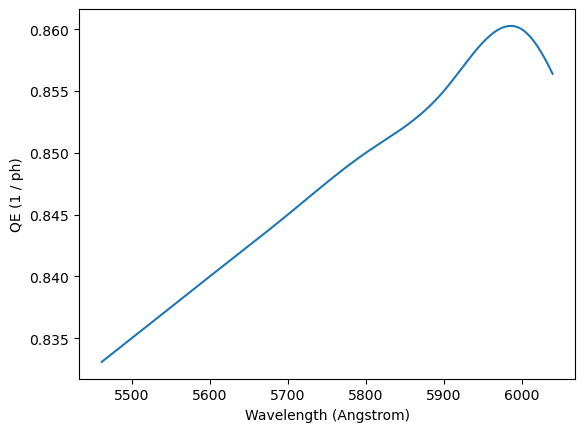

In [11]:
QEs = inst["QE"](mode["bandpass"].waveset)
plt.figure()
plt.plot(mode["bandpass"].waveset, QEs)
plt.xlabel(f'Wavelength ({mode["bandpass"].waveset.unit})')
plt.ylabel(f"QE ({QEs.unit})")

Beyond this, important values include the pixel scale, pixel pitch, and f number:

In [12]:
print(f'Pixel Scale:{inst["pixelScale"]}, Pixel Size: {inst["pixelSize"]}, F number: {inst["fnumber"]}')

Pixel Scale:0.02182234513828781 arcsec, Pixel Size: 1.3e-05 m, F number: 56.73809735954825


## Starlight Suppression System Contents

Once again, we are dealing with a dictionary:

In [13]:
syst = mode["syst"]
for key in syst.keys():
    print(key)

name
csv_angsep_colname
input_angle_units
IWA
OWA
lam
BW
Rs
Nlensl
lenslSamp
koAngles_Sun
koAngles_Earth
koAngles_Moon
koAngles_Small
csv_names
occ_trans
core_thruput
core_mean_intensity
core_area
core_contrast
PSFpeak
core_platescale
core_stability
core_stability_setting
AvgRawContrast
ExtContStab
IntContStab
SystematicC
InitStatContrast
CGintSamp
Throughput_Data
deltaLam
core_platescale_units
contrast_floor
optics
occulter
ohTime
input_angle_unit_value


Note that the coronagraph has its own central wavelength and bandpass definition.  These could match those of the mode, but do not have to.  The `lam` value in the `starlightSuppressionSystem` is the design wavelength, whereas the one in the mode is where you're actually using the coronagraph to take observations.

A coronagraph is define via five curves, described here: https://exosims.readthedocs.io/en/latest/opticalsystem.html#standardized-coronagraph-parameters.  These include the occulter transmission, core throughput, core area, core mean intensity, and core contrast.  In addition to these, ``cgi_noise`` (the engine behind ``corgietc``) also uses the PSF peak intensity.  All of these curves are parameterized by angular separation, as coronagraph performance varies between the inner and outer working angles (IWA/OWA), but must also be parametrized by observing wavelength to account for the case where we are observing in a wavelength that is different from the coronagrph's design wavelength (the impact of the wavelength change is a linear scaling of the angular separation - see the docs linked above for more details).  

Thus, when using any of these to compute values, we need to provide both an angular separation and a wavelength.  For example:

In [14]:
syst["core_contrast"](mode["lam"], syst["IWA"])

5.56e-09

Once again, we can plot the entirety of the curve by supplying many angular separation values:

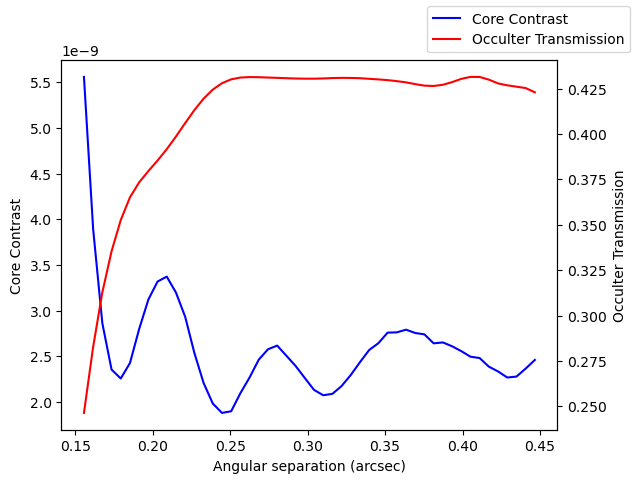

In [15]:
WAs = np.linspace(syst["IWA"].value, syst["OWA"].value)*syst["OWA"].unit
f, a1 = plt.subplots()
plt.plot(WAs, syst["core_contrast"](mode["lam"], WAs), 'b', label="Core Contrast")
a1.set_xlabel(f"Angular separation ({WAs.unit})")
a1.set_ylabel("Core Contrast")
a2 = a1.twinx()
a2.plot(WAs, syst["occ_trans"](mode["lam"], WAs),'r', label="Occulter Transmission")
a2.set_ylabel("Occulter Transmission")
f.legend();